<a href="https://colab.research.google.com/github/newmantic/GARCH-/blob/main/GARCH_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Estimated GARCH(1,1) parameters: omega=0.0761, alpha=0.0711, beta=0.8725
Forecasted variance for the next 10 steps: [31.59429879 29.88796507 28.27789555 26.7586594  25.32513219 23.97247858
 22.69613602 21.49179935 20.35540632 19.28312382]


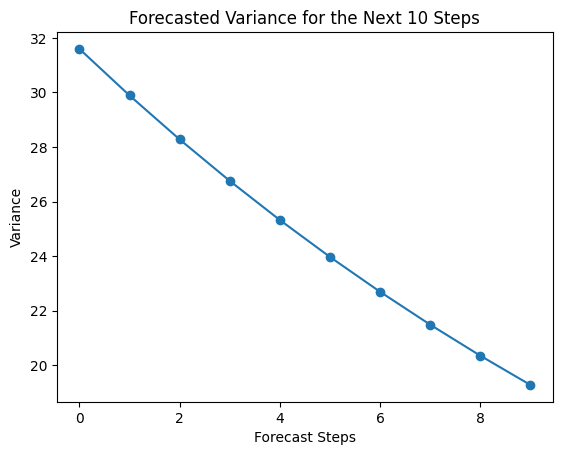

In [11]:
import numpy as np
import pandas as pd
from scipy.optimize import minimize

def garch_log_likelihood(params, returns):
    """
    Compute the log-likelihood for a GARCH(1,1) model.

    :param params: Array of GARCH(1,1) parameters [omega, alpha, beta]
    :param returns: Array of returns
    :return: Negative log-likelihood value
    """
    omega, alpha, beta = params
    T = len(returns)
    variance = np.zeros(T)
    log_likelihood = 0

    variance[0] = np.var(returns)  # Initialize variance with the sample variance

    for t in range(1, T):
        variance[t] = omega + alpha * (returns[t-1] ** 2) + beta * variance[t-1]
        log_likelihood += -0.5 * (np.log(2 * np.pi) + np.log(variance[t]) + (returns[t] ** 2) / variance[t])

    return -log_likelihood

def fit_garch(returns):
    """
    Fit a GARCH(1,1) model to the returns data.

    :param returns: Array of returns
    :return: Estimated parameters [omega, alpha, beta]
    """
    initial_params = [0.1, 0.1, 0.8]
    bounds = [(0, 1), (0, 1), (0, 1)]
    result = minimize(garch_log_likelihood, initial_params, args=(returns,), bounds=bounds)
    return result.x

def garch_forecast(returns, params, steps=10):
    """
    Forecast future variance using a fitted GARCH(1,1) model.

    :param returns: Array of returns
    :param params: Estimated GARCH(1,1) parameters [omega, alpha, beta]
    :param steps: Number of steps to forecast
    :return: Forecasted variances
    """
    omega, alpha, beta = params
    T = len(returns)
    variance = np.zeros(T + steps)  # Allocate enough space for both historical and forecasted variances

    # Compute variance for historical data
    variance[0] = np.var(returns)  # Initialize with sample variance
    for t in range(1, T):
        variance[t] = omega + alpha * (returns[t-1] ** 2) + beta * variance[t-1]

    # Forecast future variances using the last computed variance
    for t in range(T, T + steps):
        returns_squared = variance[t-1]  # Use the last variance as a proxy for the squared return
        variance[t] = omega + alpha * returns_squared + beta * variance[t-1]

    return variance[-steps:]

# Testable Example with Drastic Shocks

# Generate synthetic returns data with large shocks
np.random.seed(42)
returns = np.random.normal(0, 1, 990)  # Simulate 990 normal daily returns
shocks = np.array([10, -10, 5, -5, 8, -8, 12, -12, 7, -7])  # Introduce large shocks
returns = np.concatenate((returns, shocks))

# Fit GARCH(1,1) model
garch_params = fit_garch(returns)
print(f"Estimated GARCH(1,1) parameters: omega={garch_params[0]:.4f}, alpha={garch_params[1]:.4f}, beta={garch_params[2]:.4f}")

# Forecast future volatility
forecasted_variance = garch_forecast(returns, garch_params, steps=10)
print(f"Forecasted variance for the next 10 steps: {forecasted_variance}")

# Optional: Plot the forecasted variance
import matplotlib.pyplot as plt

plt.plot(forecasted_variance, marker='o')
plt.title('Forecasted Variance for the Next 10 Steps')
plt.xlabel('Forecast Steps')
plt.ylabel('Variance')
plt.show()